In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as pt
import torch.nn as nn

In [2]:
def V_step(V, F):
    """
    Computes next position given current position and forcing inputs
    V: car's current position in 6D space, (x , y, theta, s, omega, t)
    F: current forcing inputs, (phi, psi, dt)
    """
    phi = F[0]  # linear acceleration
    psi = F[1]  # angluar acceleration
    dt = F[2]   # timestep size
    dt2 = dt*dt/2

    x = V[0]    # x coordinate
    y = V[1]    # y coordinate
    a = V[2]    # angle
    s = V[3]    # speed
    w = V[4]    # angular speed
    t = V[5]    # time

    _0 = pt.zeros_like(x)
    _1 = pt.ones_like(x)

    A1 = pt.stack([x, y, a, s, w, t])
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0, _0])
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0, _0])
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0, _0])
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0, _0])
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1, _0])
    C3 = pt.stack([_0, _0, _1, _0, _0, _0])
    C = dt*C2 + dt2*C3

    D = pt.stack([_0, _0, _0, _0, _0, _1])  # this is correct

    return A + phi*B + psi*C + dt*D

def loss_fun(Y, T, F, scale=None):
    scale = pt.tensor([1, 1, 1, 1, 1]) if scale is None else scale
    diff = (Y[0:5]-T) * scale
    target_loss = pt.dot(diff, diff)                # loss from missing the target
    time_loss = Y[5]                                # loss by taking too long
    l2_loss = pt.mean(F[:,0:2]**2)                  # loss by using too much force
    return target_loss, time_loss, l2_loss

def get_forcing(V, F):
    # limits based on current speed

    S = abs(V[...,3])
    turningRadius = 1

    psi_lim = pt.min(S / turningRadius, 0.8 * pt.ones_like(S))

    F_limited = pt.stack([
        pt.clamp(F[...,0], -0.8, 0.8),
        pt.clamp(F[...,1], -psi_lim, psi_lim),
        pt.clamp(F[...,2], 0.001, 0.25)
        ], dim=-1)

    return F_limited

# Compute a path while modifing V_mat and F_mat inplace
def compute_path_autograd(V0, F_request, target):
    V_list = [V0]
    F_true = []

    for i in range(F_request.shape[0]):
        F_true.append(get_forcing(V_list[i], F_request[i]))
        V_list.append(V_step(V_list[i], F_true[i]))
        # with pt.no_grad():
        #     F_request.data[i] = F_true[i]

    loss = loss_fun(V_list[-1], target, F_request)


    return V_list, loss

def to_tensor(V_mat):
    ten = pt.zeros((len(V_mat), V_mat[0].shape[0]))
    for i in range(len(V_mat)):
        ten[i] = V_mat[i].detach().cpu()
    return ten[:,0:5], ten[:,5]

In [3]:
def plot_traj(V_records, target, alphas=None, ax=None, figsize=(8,6)):
    num_records = V_records.shape[0]

    if alphas is None:
        alphas = np.ones(num_records)
        alphas[:-1] = np.linspace(0.1, 0.8, num_records-1)
    
    arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

    fig_exists = False

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        fig_exists = True
    
    ax.scatter(V_records[0,0,0], V_records[0,0,1], marker='*', color='sandybrown', s=200, zorder=6, label='Start')
    ax.scatter(target[0], target[1], marker='s', color='sandybrown', s=120, label='Target')
    ax.scatter(V_records[-1,-1,0], V_records[-1,-1,1], marker='o', color='dodgerblue', s=120, zorder=10, label='End')


    ax.arrow(*V_records[0,0,0:2], *arrowDir(V_records[0,0]), color='sandybrown', head_width=0.15, head_length=0.15, lw=4, zorder=2)
    ax.arrow(*target[0:2], *arrowDir(target.numpy()), color='sandybrown', head_width=0.15, head_length=0.15, lw=4, zorder=2)
    ax.arrow(*V_records[-1,-1,0:2], *arrowDir(V_records[-1,-1]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=3, zorder=2)

    for i in range(num_records):
        lw = 1 if alphas[i] != 1 else 2
        ax.plot(V_records[i,:,0], V_records[i,:,1], color='dodgerblue', lw=lw, alpha=alphas[i])

    ax.set_title('Trajectory')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.axis('equal')
    ax.grid()
    ax.legend()

    return (fig, ax) if fig_exists is True else ax


def plot_forcing(F_records, ts_records, alphas=None, ax=None, figsize=(8,6)):
    num_records = F_records.shape[0]

    if alphas is None:
        alphas = np.ones(num_records)
        alphas[:-1] = np.linspace(0.1, 0.8, num_records-1)
    
    fig_exists = False
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=figsize)
        fig_exists = True

    for i in range(num_records-1):
        lw = 1.5 if alphas[i] != 1 else 2
        plt.plot(ts_records[i,:-1].detach().numpy(), F_records[i,:,0].detach().numpy(), color='deeppink', lw=lw, alpha=alphas[i])
        plt.plot(ts_records[i,:-1].detach().numpy(), F_records[i,:,1].detach().numpy(), color='limegreen', lw=lw, alpha=alphas[i])
    
    lw = 1 if alphas[i] != 1 else 2
    plt.plot(ts_records[-1,:-1].detach().numpy(), F_records[-1,:,0].detach().numpy(), color='deeppink', lw=lw, alpha=alphas[-1], label='Acceleration Force')
    plt.plot(ts_records[-1,:-1].detach().numpy(), F_records[-1,:,1].detach().numpy(), color='limegreen', lw=lw, alpha=alphas[-1], label='Turning Force')

    left, right = ax.get_xlim()
    ax.plot([left, right], [0.8, 0.8], '--k', lw=1.5)
    ax.plot([left, right], [-0.8, -0.8], '--k', lw=1.5)
    
    ax.legend()
    ax.set_title('Forcing Terms')
    ax.set_xlabel('Time')
    ax.set_ylabel('Force')
    ax.set_ylim([-0.85, 0.85])
    ax.grid()

    return (fig, ax) if fig_exists is True else ax

In [4]:
t0 = 0
t1 = 5.5       # designed for 5.5
dt_max = 0.25
n_steps = 2**np.ceil(np.log2((t1 - t0)/ dt_max)).astype(int)
print(f'Path has {n_steps} steps with size {(t1-t0)/n_steps:0.3g}s')

v0 = pt.tensor([0, 0, 0.2, 1, 1, t0], requires_grad=True)
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])

F_mat = nn.Parameter(0 * pt.randn((n_steps, 3)))
V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)

optim = pt.optim.AdamW([F_mat], lr=6e-2, weight_decay=0)


pt.autograd.set_detect_anomaly(False)

figaxs = None
iters = 500
plot_freq = 25
num_records = iters//plot_freq if iters%plot_freq == 0 else iters//plot_freq + 1

V_records = pt.zeros((num_records, n_steps+1, 5))
F_records = pt.zeros((num_records, n_steps, 3))
ts_records = pt.zeros((num_records, n_steps+1))

for i in range(iters):
    is_record_step = (i % plot_freq == plot_freq - 1) or (i== iters - 1)
    record_idx = i // plot_freq
    
    optim.zero_grad()
    V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)


    dist = target_loss ** 0.5

    l2_coef = -1e0
    time_coef = 1e-8


    loss = target_loss + time_coef*time_loss + l2_coef*l2_loss
    loss.backward()
    optim.step()

    with pt.no_grad():
        F_mat.copy_(get_forcing(pt.stack(V_mat[:-1]), F_mat))

    if i % plot_freq == plot_freq-1:
        print(f"Iteration {i+1}, Target Dist: {target_loss ** 0.5}, End Time: {time_loss}, L2: {l2_loss}")
        if i < iters-1:
            traj, ts = to_tensor(V_mat)
            V_records[record_idx,:,:] = traj
            F_records[record_idx,:,:].copy_(F_mat)
            ts_records[record_idx,:] = ts

traj, ts = to_tensor(V_mat)
traj, ts = to_tensor(V_mat)
V_records[record_idx,:,:] = traj
F_records[record_idx,:,:].copy_(F_mat)
ts_records[record_idx,:] = ts

Path has 32 steps with size 0.172s
Iteration 25, Target Dist: 2.145601511001587, End Time: 4.727670669555664, L2: 0.3682080805301666
Iteration 50, Target Dist: 0.48604723811149597, End Time: 4.1832475662231445, L2: 0.3622404932975769
Iteration 75, Target Dist: 0.19671988487243652, End Time: 4.242238998413086, L2: 0.37756064534187317
Iteration 100, Target Dist: 0.05343916639685631, End Time: 4.334927558898926, L2: 0.3976600766181946
Iteration 125, Target Dist: 0.01617209054529667, End Time: 4.313175678253174, L2: 0.4242967963218689
Iteration 150, Target Dist: 0.011453243903815746, End Time: 4.282044410705566, L2: 0.45546549558639526
Iteration 175, Target Dist: 0.021372487768530846, End Time: 4.258173942565918, L2: 0.47783517837524414
Iteration 200, Target Dist: 0.014592204242944717, End Time: 4.249805450439453, L2: 0.5045517086982727
Iteration 225, Target Dist: 0.025253785774111748, End Time: 4.232800483703613, L2: 0.536297082901001
Iteration 250, Target Dist: 0.02254365384578705, End T

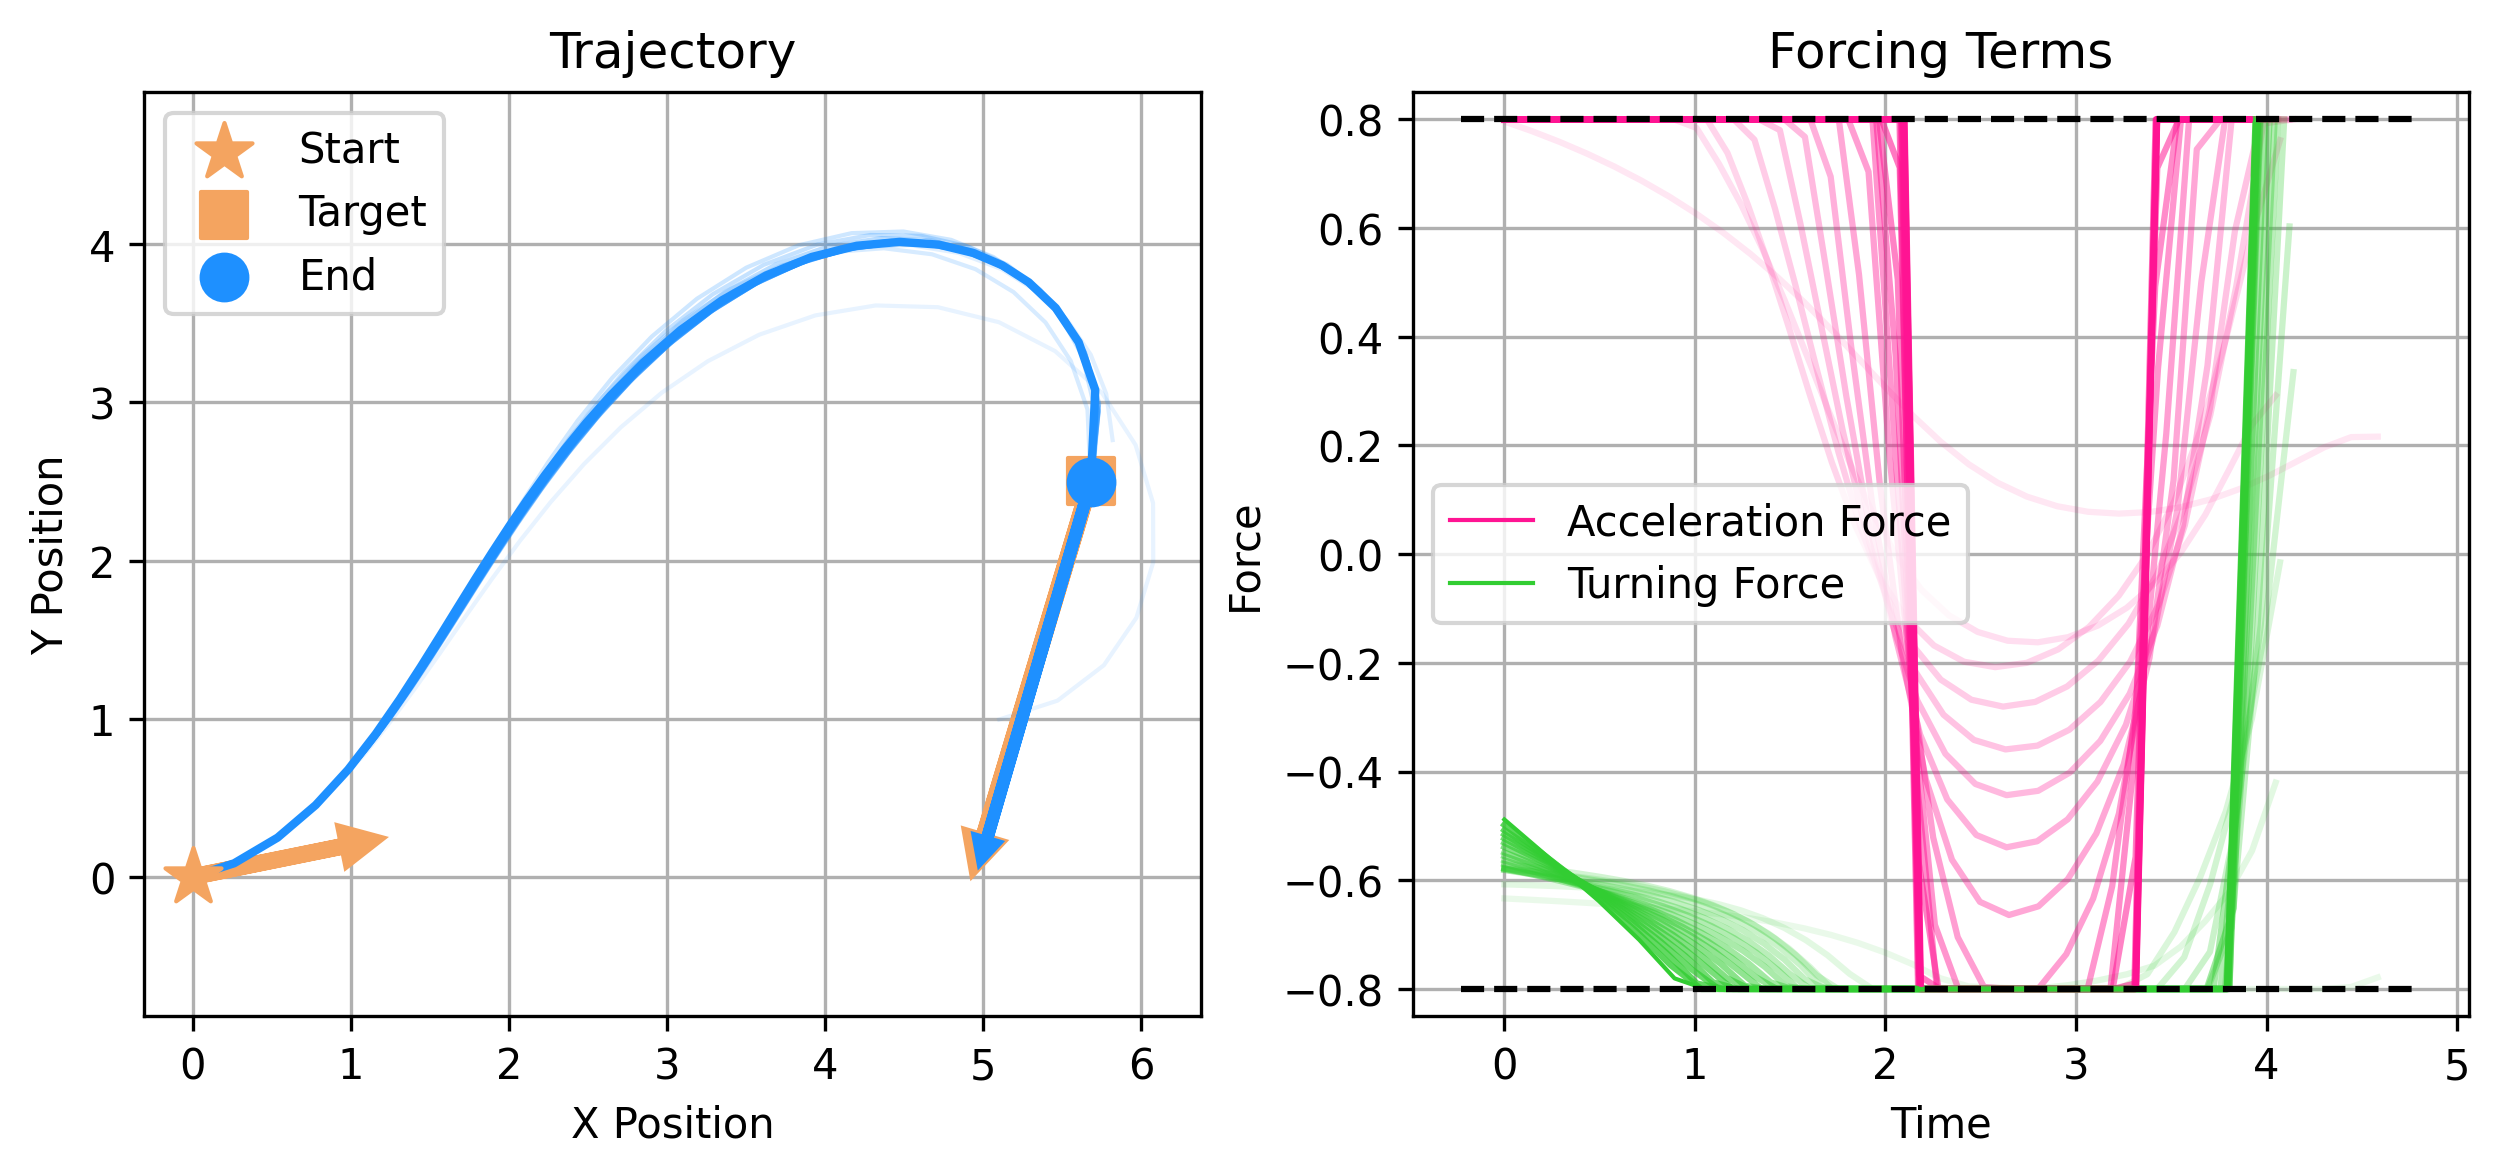

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), dpi=300)
plot_traj(V_records, target, ax=ax1)
plot_forcing(F_records, ts_records, ax=ax2)
plt.show()

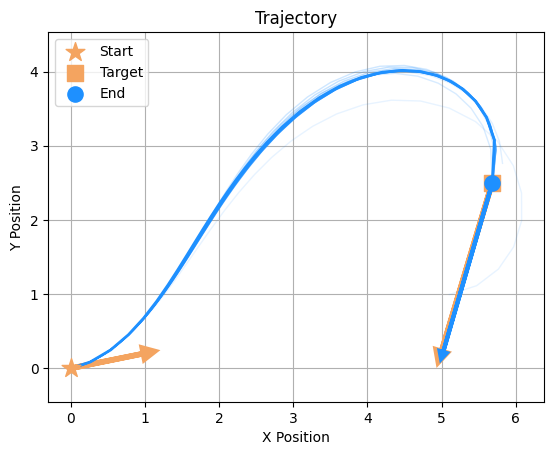

In [6]:
fig, ax = plt.subplots()
plot_traj(V_records, target, ax=ax)
plt.show()

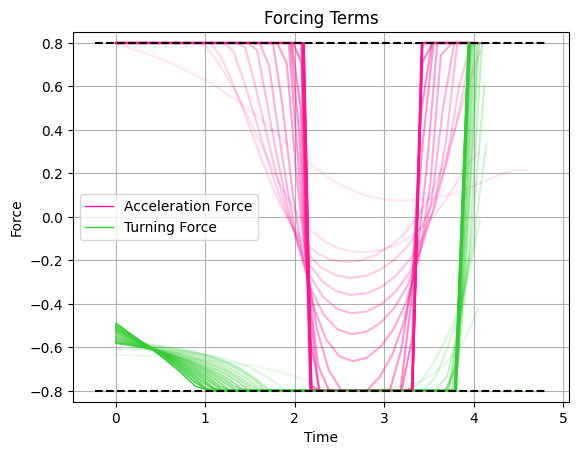

In [7]:
fig, ax = plt.subplots()
plot_forcing(F_records, ts_records, ax=ax)
plt.show()